# 1. Bayesian optimization

Content
1. Bayesian optimization overview
2. One dimensional example
3. AutoML: optimization of hyperparameters for machine learning model
4. Implementation of bayesian optimization

# When Bayesian optimization?

* Optimization of "heavy" functions 
* The target function is a blackbox, typically noisy, while smooth


* Construction a regression model using available data
* Take into account uncertainty of the regression model
* Gaussian process regression is OK

## Optimization workflow:
1. Construct a regression model $\hat{f}(x)$ of a function $f(x)$ using the sample $D = \{(x_i, f(x_i))\}_{i = 1}^n$
2. Select a new point that maximize an acquisition function
$$
x_{new} = \arg\max\limits_x a(x)
$$
3. Calculate $f(x_{new})$ at the new point.
4. Add the pair $(x_{new}, f(x_{new}))$ to the sample $D$.
5. Update the model $\hat{f}(x)$ and go to step 2.

## Examples of the acquisation functions 

#### Upper confidence bound (UCB) 

$$
UСB(x) = \hat{f}(x) + \beta \hat{\sigma}(x),
$$
$\hat{f}(x), \hat{\sigma}(x)$ - mean and standard deviation of the Gaussian process regression model at $x$.
  
*Ex:* $\hat{\mu} + 2*\hat{\sigma}$ - верхняя граница 95%-ого доверительного интервала

#### Probability of Improvement (PI)

$$
PI(x) = P \left ( \hat{f}(x) < f_{min} \right )
$$

#### Expected Improvement (EI) 

$$
EI(x) = \mathbb{E}_{p(\hat{f})} \max(0, f_{min} - \hat{f}(x)). 
$$


Usually we use logarithm of EI.

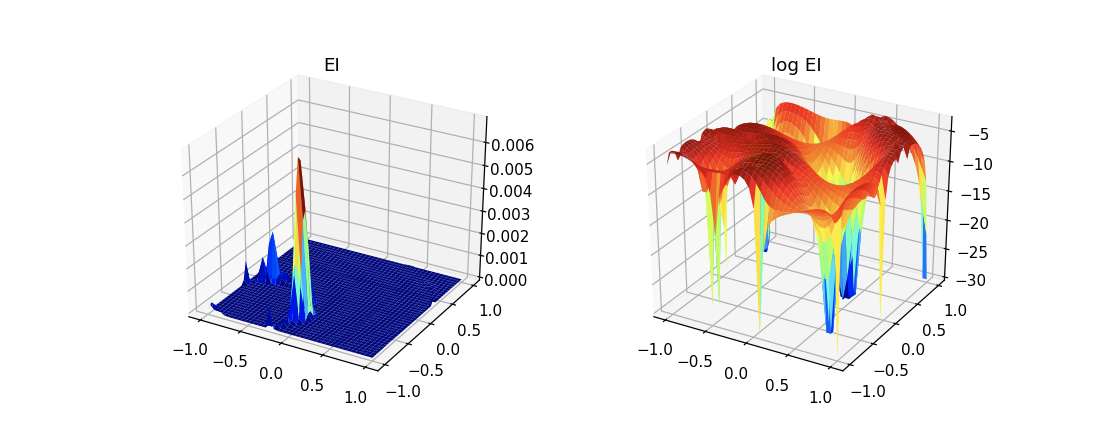

## Additional libraries

We need libraries for
* Gaussian process regression **GPy** (see previous seminar)
* Gaussian process regression-based Bayesian optimization **GPyOpt**

See more use cases of **GPyOpt** at http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/index.ipynb

To install GPyOpt run the following line

For python-3.7 try

In [ ]:
# git clone https://github.com/SheffieldML/GPy
# find GPy -name '*.pyx' -exec cython {} ;
# pip install GPy/

In [1]:
!pip install emcee
!pip install GPyOpt

  Stored in directory: C:\Users\imaksimov002\AppData\Local\pip\Cache\wheels\2f\5d\a5\78f84e23329ad7d9b1787c9d24371100cae74cdefe25eba50d
Successfully built emcee


You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
% matplotlib inline


import GPy
import GPyOpt
import matplotlib.pyplot as plt
import numpy as np

# auxiliary functions
import utils

from IPython.display import clear_output
from tqdm import trange

# 3. One dimensional example

We demonstrate concepts using one-dimensional example.

Let us consider Bayesian optimization for one-dimensional function **Forrester**:
$$
f(x) = (6 x - 2)^2 \sin(12 x - 4).
$$

The optimization problem is the following:
$$
f(x) \rightarrow \min, x \in [0, 1].
$$

In [3]:
# we can load it from GPyOpt library
forrester_function = GPyOpt.objective_examples.experiments1d.forrester()

In [4]:
forrester_function.f(np.array([0.5]))

array([[0.90929743]])

In [5]:
forrester_function.bounds

[(0, 1)]

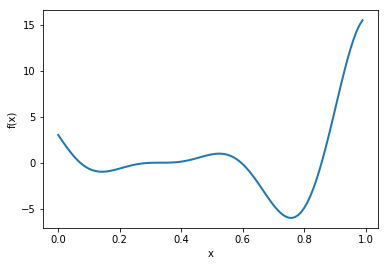

In [6]:
forrester_function.plot()

In [7]:
# Select the region where we search the optimum
space = [{'name': 'x', 'type': 'continuous', 'domain': (0, 1)}]
design_region = GPyOpt.Design_space(space=space)

In [8]:
# Select the initial design
from numpy.random import seed # fixed seed
seed(123456)

initial_sample_size = 5
initial_design = GPyOpt.experiment_design.initial_design('random', design_region, initial_sample_size)

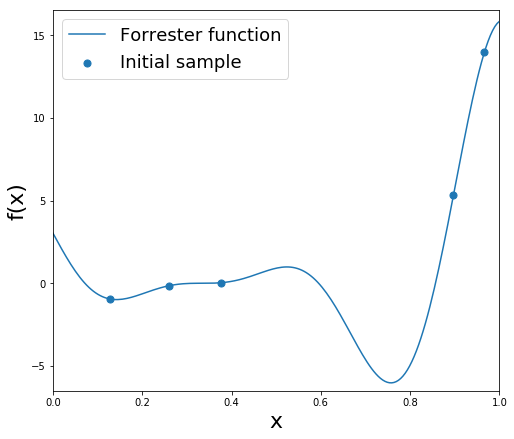

In [9]:
uniform_dense_grid = np.linspace(0, 1, 200).reshape(-1, 1)

# plot function: curve and values at the initial design points
utils.plot_one_dimensional_function(forrester_function, 
                                    uniform_dense_grid, 
                                    initial_design)

## We defined the problem - now we create a machine to solve it

1. A black box that evaluates the target function
2. What kind of the regression model we need
3. How do we optimize the acquisition function
4. What kind of the acquisition function we use
5. Should we use optimizer in batch or continuous mode?

In [10]:
# The target function
objective = GPyOpt.core.task.SingleObjective(forrester_function.f)

# Model type
gp_model = GPyOpt.models.GPModel(exact_feval=True, optimize_restarts=10, verbose=False) 
# exact_feval - are evaluations exact?
# optimize_restarts - number of restarts at each step
# verbose - how verbose we are

# Optimizer of the acquisition function, the default is 'LBFGS'
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(design_region)

# The acquisition function is expected improvement (EI)
acquisition_function = GPyOpt.acquisitions.AcquisitionEI(gp_model, design_region, optimizer=aquisition_optimizer)

# How we collect the data: at each step add just 1 data point
evaluator = GPyOpt.core.evaluators.Sequential(acquisition_function)

In [11]:
# Now we are ready to construct the machine
bayesian_optimizer = GPyOpt.methods.ModularBayesianOptimization(
    gp_model, design_region, objective, acquisition_function, evaluator, initial_design)

### Run the first six iterations

In [12]:
# Stopping criteria
max_time = None 
max_number_of_iterations = 5
tolerance = 1e-8 # distance between consequitive observations

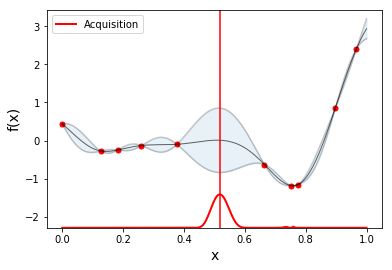

In [13]:
# Run five iterations
for iteration in range(max_number_of_iterations):
    bayesian_optimizer.run_optimization(max_iter=1, max_time=max_time, 
                                        eps=tolerance, verbosity=False) 
  
    utils.plot_acquisition(bayesian_optimizer)
    clear_output(wait=True)

### Now we run more iterations - 25

In [14]:
bayesian_optimizer = GPyOpt.methods.ModularBayesianOptimization(
    gp_model, design_region, objective, acquisition_function, evaluator,
    initial_design)

max_number_of_iterations = 25
bayesian_optimizer.run_optimization(max_iter=max_number_of_iterations,
                                    max_time=max_time, eps=tolerance, verbosity=False)

### Analyze problems

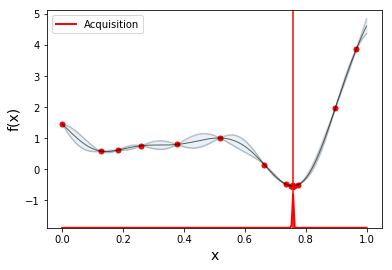

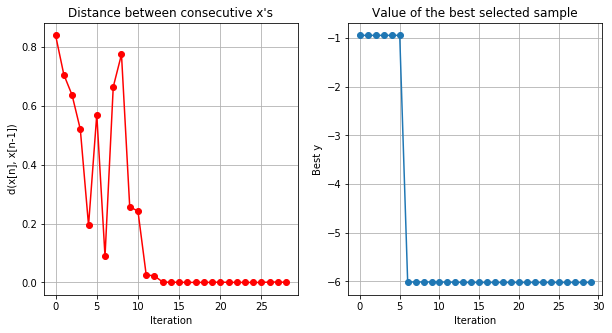

In [15]:
utils.plot_acquisition(bayesian_optimizer)
bayesian_optimizer.plot_convergence()

In [16]:
print('Obtained xmin:  {:.3f}, real xmin: '
      '{:.3f} (approximate)'.format(bayesian_optimizer.x_opt[0], forrester_function.min))
print('Obtained fmin: {:.3f}, real fmin: '
      '{:.3f} (approximate)'.format(bayesian_optimizer.fx_opt, forrester_function.fmin))

Obtained xmin:  0.757, real xmin: 0.780 (approximate)
Obtained fmin: -6.021, real fmin: -6.000 (approximate)


### Compare various acquisition functions EI, UCB and PI

In [17]:
# Your code below. Use EI, UCB and PI acquisition functions
number_of_runs = 10
criteria_list = ['EI', 'UCB', 'PI']
history = dict((criterion, []) for criterion in criteria_list)

for criterion in criteria_list:
    print(criterion)
    for index in trange(number_of_runs):
        seed(index)
        history[criterion].append(utils.run_bayesian_optimization(criterion))
        
    history[criterion] = np.array(history[criterion])

EI


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.50s/it]


UCB


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.62s/it]


PI


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.74s/it]


In [18]:
initial_sample_size = 5

for criterion in history:
    history[criterion] = history[criterion][:, initial_sample_size:]

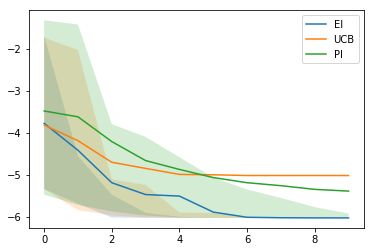

In [19]:
interations_number = 10
iterations = range(interations_number)

lower_percentile = 25
upper_percentile = 75

for criterion in history:

    plt.plot(iterations, np.mean(history[criterion], axis=0), label=criterion)
    plt.fill_between(iterations, 
                     np.percentile(history[criterion], axis=0, q=lower_percentile),
                     np.percentile(history[criterion], axis=0, q=upper_percentile),
                     alpha=0.2)

plt.legend(loc='upper right')

NB: EI is the best almost for all cases

# 3. Bayesian optimization for the parameters of Gradient boosting

Now we optimize hyperparameters for Gradient boosting of decision trees.

In [20]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

If lightgbm is not installed, please run the following cell

In [ ]:
!pip install lightgbm

### We predict defaults for the classification problem

The goal is to predict if the two years absense of payments occur.

In [21]:
# Load the training sample
data = pd.read_csv('training_data.csv')
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [22]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data['SeriousDlqin2yrs']

In [23]:
import lightgbm as lgb


def wrap_params(params, space):
    wrapped_params = []
    for p in params:
        p_dict = dict(zip([element['name'] for element in space], p))
        
        for key in p_dict:
            param_description = [x for x in space if x['name'] == key][0]
            if param_description['type'] == 'discrete':
                p_dict[key] = int(p_dict[key])
        wrapped_params.append(p_dict)

    return wrapped_params
    
def get_cv_quality(parameters):
    r"""
  
    Quality of model using given hyperparameters

    Inputs
    --------
    params_list : array-like of dict
      numpy array of hyperparameteres specified in the same way as a domain

    Outputs
    --------
    minus_roc_auc : float
      minus mean value of ROC AUC calculated via cross validation
    """
    test_score_list = []
    
    if not isinstance(parameters, list):
        parameters = [parameters]
    
    for params_dict in parameters:
        model = lgb.LGBMClassifier()
      
        model.set_params(**params_dict)
        test_score = -np.mean(cross_validate(model, 
                              X, y, scoring='roc_auc')['test_score'])
        test_score_list.append(test_score)
    return test_score

### Run Bayesian optimization

In [24]:
# Define the region
space = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.05, 0.2)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain': np.arange(10, 100)},
    {'name': 'subsample', 'type': 'continuous', 'domain': (0.75, 1.)}
]

design_region = GPyOpt.Design_space(space=space)

In [25]:
opt_problem = GPyOpt.methods.BayesianOptimization(
    lambda x: get_cv_quality(wrap_params(x, space)),  
    domain=space,
    acquisition_type='EI')

opt_problem.run_optimization(max_iter=50) # +5 points for initial exploration
opt_problem.x_opt

array([ 0.05, 31.  ,  1.  ])

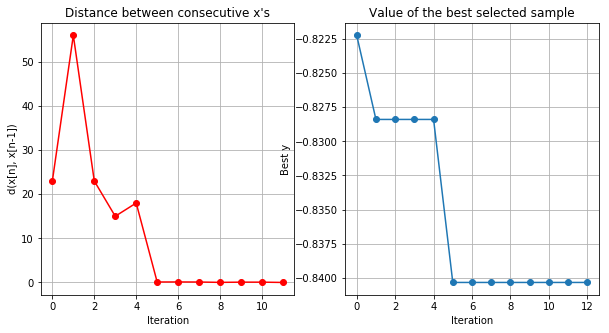

In [26]:
opt_problem.plot_convergence()

Second plot - CV loss (-"ROC-AUC")

## Validate parameters using a test sample

In [27]:
# Load the testing sample
test_data = pd.read_csv('test_data.csv')

X_test = test_data.drop('SeriousDlqin2yrs', axis=1)
y_test = test_data['SeriousDlqin2yrs']

#### Model with default parameters

In [28]:
initial_model = lgb.LGBMClassifier()
initial_model.fit(X, y)
proba_predicted = initial_model.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, proba_predicted))

0.8028561649532023


#### Model with tuned parameters

In [29]:
best_model = lgb.LGBMClassifier(learning_rate=opt_problem.x_opt[0], 
                                n_estimators=int(opt_problem.x_opt[1]),
                                subsample=opt_problem.x_opt[2])
best_model.fit(X, y)
proba_predicted = best_model.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, proba_predicted))

0.8243274625586172


# Tree Parzen Estimator (TPE)

Expected Improvement can be calculated without GP model

$$
p(y | x) \propto p(x | y) p(y)
$$

$$
p(x | y) = \begin{cases}
    l(x), \mbox{ if} y < y^* \\
    g(x), \mbox{ if} y \ge y^* \\
\end{cases},
$$
where $y^*$ is some quantile $\gamma$ of $y$, i.e., $p(y < y^*) = \gamma$.

$$
EI(x) \propto \left ( \gamma + \frac{g(x)}{l(x)}(1 - \gamma) \right )^{-1}
$$
$l(x)$ and $g(x)$ are estimated using KDE (kernel density estimate)

### Task: prove the expression for EI above

In [30]:
!pip install --upgrade git+git://github.com/hyperopt/hyperopt.git

  Cloning git://github.com/hyperopt/hyperopt.git to c:\users\imaksi~1\appdata\local\temp\pip-req-build-s1ruta78
  Stored in directory: C:\Users\IMAKSI~1\AppData\Local\Temp\pip-ephem-wheel-cache-u5i2a2_z\wheels\c9\13\71\0d7783dc440af384cb42aff4d1f3b1ca565115fcda10588c9c
Successfully built hyperopt


You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [31]:
from hyperopt import fmin, hp, tpe


params_names = ['learning_rate', 'n_estimators', 'subsample']

space = {
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
    'subsample': hp.uniform('subsample', 0.75, 1.)
}

types = {
    'learning_rate': 'continuous',
    'n_estimators': 'discrete',
    'subsample': 'continuous'
}

random_state = np.random.RandomState(42)

def wrap_params(params, types):
    wrapped_params = params.copy()
    for key in wrapped_params:
        if types[key] == 'discrete':
            wrapped_params[key] = int(wrapped_params[key])
            
    
        # if key == 'n_estimators':
        #     wrapped_params[key] = 210 - wrapped_params[key]
    
    return wrapped_params


best = fmin(lambda x: get_cv_quality(wrap_params(x, types)),
            space=space,
            algo=tpe.suggest,
            max_evals=55, rstate=random_state)
best

100%|██████████████████████████████████████████████████| 55/55 [00:39<00:00,  1.93it/s, best loss: -0.8421071100948336]


{'learning_rate': 0.050419458951639406,
 'n_estimators': 35.0,
 'subsample': 0.7978783677288704}

In [32]:
best_model = lgb.LGBMClassifier(**wrap_params(best, types))
best_model.fit(X, y)
proba_predicted = best_model.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, proba_predicted))

0.8295666971614282


## Implementation of bayesian optimization

This is the function we will optimize

In [33]:
import GPy

import bayes_opt


def f(x):
    return (6 * x - 2)**2 * np.sin(12 * x - 4)  

def get_1d_data():
    np.random.seed(239)
    x_train = np.array([0.0, 0.58, 0.38, 0.95]).reshape(-1, 1)
    y_train = f(x_train)
    return x_train, y_train

In [34]:
x_train, y_train = get_1d_data()
kernel = GPy.kern.RBF(1, variance=0.5, lengthscale=0.2)
model = GPy.models.GPRegression(x_train, y_train, kernel)

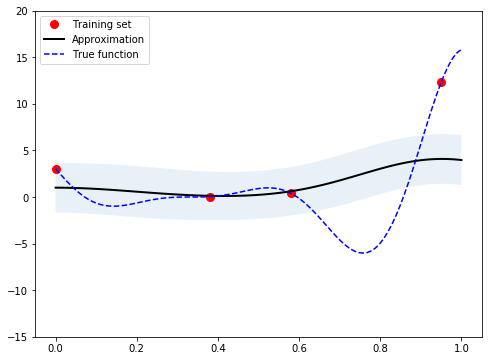

In [35]:
x_grid = np.linspace(0, 1, 100).reshape(-1, 1)
y_grid = f(x_grid)
prediction, std = model.predict(x_grid)
prediction = prediction.ravel()
std = std.ravel()
plt.figure(figsize=(8, 6))
plt.plot(x_train, y_train, 'or', markersize=8, label='Training set')
plt.plot(x_grid, prediction, '-k', linewidth=2, label='Approximation')
plt.fill_between(x_grid.ravel(), prediction - 2 * std, prediction + 2 * std, alpha=0.1)
plt.plot(x_grid, y_grid, '--b', label='True function')
plt.ylim([-15, 20])
plt.legend(loc='best')

### Task 1. Implement multi-start optimization of the acquisition function

We use multistart combined with L-BFGS.

Multistart procedure:
1. Generate an initial sample $x_1, \ldots, x_n$. Evaluation the acquisation function at each point and get $(a(x_1), \ldots, a(x_n))$.
2. Select $k$ best points.
3. Use each point as the initial point for running (L-BFGS) and get $k$.
4. Select the best point.

In [42]:
from scipy.optimize import minimize
from bayes_opt import log_expected_improvement,
from bayes_opt import lower_confidence_bound as lcb


def get_new_point(model, lb, ub, data=None, multistart=10, criterion='ei', k=1, random_state=None):
    """
    Parameters:
    ===========
        model - GP model of the objective function
        lb, ub - array-like, lower and upper bounds of x
        data - tuple(x_train, y_train)
        multistart - number of multistart runs
        criterion - aqcuisition function, by default EI
        k - parameter of the LowerConfidenceBound function
        random_state - np.random.RandomState
    Returns
    =======
        tuple - argmin of the objective function and min value of the objective 
    """
    if random_state is None:
        random_state = np.random.RandomState()

    lb = np.array(lb).reshape(1, -1)
    ub = np.array(ub).reshape(1, -1)
    
    # 1. Generate inital X points (number of points == multistart) in [lb, ub]
    
    ######## Your code here ########
    x_random = np.random.uniform(low=lb, high=ub, size= (len(lb), multistart))

    
    ######## ########
    def objective(x):
        if x.ndim == 1:
            x = x.reshape(1, -1)
        mean_values, variance = model.predict(x)
        std_values = np.sqrt(variance)
        if criterion == 'ei':
            return -log_expected_improvement(mean_values, std_values, data[1].min())
        elif criterion == 'lcb':
            return lcb(mean_values, std_values, params)
        else:
            raise NotImplementedError('Criterion is not implemented!')

    criterion_value = objective(x_random)
    
    # 2. From each points from x_random run L-BFGS optimization algorithm, 
    #    choose the best result and return it
    #    Use function minimize: minimize(objective, x_init, method='L-BFGS-B',
    #                                    bounds=np.vstack((lb, ub)).T)
    #    it returns object with fields 'fun' - optimum function value, 'x' - argmin.

    best_result = None
    best_value = np.inf

    for x_init in x_random:
        optimization_result = minimize(objective, x_init, method='L-BFGS-B', 
                                       bounds=np.vstack((lb, ub)).T)   ######## Your code here ########
        if optimization_result.fun < best_value:
            best_result = optimization_result.fun   ######## Your code here ########
            best_value = optimization_result.x   ######## Your code here ########
    
    return best_result.x, best_result.fun

ImportError: cannot import name 'lcb'

In [41]:
# Check your code 
lb = [0]
ub = [1]
kernel = GPy.kern.RBF(1, variance=0.5, lengthscale=0.1)
model = GPy.models.GPRegression(x_train, y_train, kernel)
x_new, f_new = get_new_point(model, lb, ub, data=(x_train, y_train), random_state=np.random.RandomState(42))

assert(np.isclose(x_new, 0.29985639))
assert(np.isclose(f_new, 0.86480674))
print('Correct!')

NameError: name 'log_expected_improvement' is not defined

### Task 2. implement optimization step

Just follow the comments

In [ ]:
def optimization_step(x_train, y_train, kernel, objective, lb=None, ub=None, criterion='ei', k=1, plot=False):
    """
    Parameters:
    ===========
        x_train : np.array
        y_train : np.array
        kernel : GPy.kern.kernel - kernel to be used with GP
        objective : function - function to be optimized
        lb : array-like - lower bound for x
        ub : array-like - upper bound for x
        criterion : str - criterion to be optimized (a.k.a. acquisition function)
        k : float - parameter for UCB acquisition function
        plot : bool - whether to plot result or not
        
    Returns
    =======
        (np.array, np.array, GPy.model.Model) - new training set and constructed GP model
    """
    # 1. Build GP model for given training set and kernel
    model = model.fit(x_train, y_train)
    model.optimize_restarts(...)

    # 2. Get new candidiate point
    x_new, criterion_value = get_new_point(model, lb, ub, 
                                           data=None, multistart=10, 
                                           criterion='ei', k=1, random_state=None)
    
    if plot:
        bayes_opt.plot1d(x_train, y_train, model, objective, x_new, criterion_value)
        plt.show()

    # 3. Evaluate objective at newly obtained point x_new
    y_new = model.predict(x_new)
    
    # 4. Append x_new and y_new to the training set

    x_train = x_train.append(x_new)
    y_train = y_train.append(y_new)
    return x_train, y_train, model

Check yourself

In [ ]:
x_train, y_train = get_1d_data()
kernel = GPy.kern.RBF(1, variance=0.5, lengthscale=0.2)
model = GPy.models.GPRegression(x_train, y_train, kernel)
for i in range(6):
    x_train, y_train, model = optimization_step(x_train, y_train, kernel, f,
                                                lb=[0], ub=[1], criterion='ei', plot=True)